In [414]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dense
from keras.models import model_from_yaml

3 отклонения
2 модели
2 способа
3 дальности прогноза

# ㅤㅤㅤㅤㅤㅤㅤㅤПодготовка данных и создание выборок
Буду рассматривать 3 степени зашумленности сигнала и для каждого шума буду создавать модель.
Можно ещё тренировать модели по дальности прогноза, но тогда их будет слишком много. Поэтому буду делать прогноз по оси x на 0.3, другими словами, буду прогнозировать третье значение после входных данных.

Мой подход к задаче таков: 

        

1) Создание скользящей средней, чтобы хоть как-то минимизировать шум


2) Подавать во входной слой 3 признака: ema[n-2], ema[n-1], ema[n]. Сделал это для того, чтобы была отслежена динамика     изменения ema. Потому что если просто подавать значения ema[n], признак может быть неправильно                   интерпретирован. Например, на закруглении синуса у него значения ближе к единице. И если подать просто значения 0.9,       то будет непонятно эта 0.9 во время убывающего тренда или повышающегося.

In [200]:
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)


# Написал функцию, чтобы для каждого шума не писать одно и то же
def create_data(data, n, name):   

    #Создание скользящих средних с периодом n  
    data_ema = moving_avg(data, n)
    
    #Удаляем первые члены ряда, которые соответствовали удаленным членам в процессе рассчета скользяшей средней
    output_data = data[n-1:]
    
    
    #сдвиг на 1 и 2, чтобы подавать вектор в keras из [n-2, n-1, n] элементов скользящих средних
    data_ema_shift_1 = np.roll(data_ema, 1)
    data_ema_shift_2 = np.roll(data_ema, 2)

    #Стэкнул входные данные НС, чтобы соответствовали друг другу 
    input_data = np.stack((data_ema_shift_2, data_ema_shift_1, data_ema), axis=1)
    

    # Убрал первые 2 элемента во входящих данных, так как мы делали максимальный сдвиг на 2 в скользящих
    # Также убрал последние 3 элемента у входных данных (чтобы можно было предсказать n-3 элемент) 
    # И первые 5 элементов у выходных (проверочных) данных,так как для них нет данных для предсказания и потому что был сдвиг
    #В черновике юпитера написал все сдвиги и дропы наглядно, для проверки себя и в целом
    
    input_data, output_data = input_data[2:len(input_data)-3], output_data[5:]


    # ~50% данных в обучающую выборку, ~25% на валидацию, ~25% на тестовую 
    input_train, input_test = input_data[:1500], input_data[1500:]
    output_train, output_test = output_data[:1500], output_data[1500:]
    
    #Сохранение в csv
    np.savetxt('input_train_' + name + '.csv', input_train, delimiter=',')
    np.savetxt('input_test_' + name + '.csv', input_test, delimiter=',')
    
    np.savetxt('output_train_' + name + '.csv', output_train, delimiter=',')
    np.savetxt('output_test_' + name + '.csv', output_test, delimiter=',')
    

    
#Создание массива значений синуса с шагом 0.1
x = np.arange(0, 200, 0.1)
sin = np.sin(x)

#Создание шума с разным отклонением
sin_with_noise_0_1  = sin + np.random.normal(0, 0.1, sin.shape)
sin_with_noise_0_3  = sin + np.random.normal(0, 0.3, sin.shape)
sin_with_noise_0_5  = sin + np.random.normal(0, 0.5, sin.shape)    
    
    
create_data(sin_with_noise_0_1, 8, 'sin_with_noise_0_1')    
create_data(sin_with_noise_0_3, 8, 'sin_with_noise_0_3') 
create_data(sin_with_noise_0_5, 8, 'sin_with_noise_0_5') 

#Сохранил также и то что сгенерировал во время написания этого кода 
np.savetxt('sin_with_noise_0_1.csv', sin_with_noise_0_1, delimiter=',')
np.savetxt('sin_with_noise_0_3.csv', sin_with_noise_0_3, delimiter=',')
np.savetxt('sin_with_noise_0_5.csv', sin_with_noise_0_5, delimiter=',')
    
  

Небольшой комментарий: не увидел большого смысла стандартизировать данные, так как рассматриваем только сам зашумленный синус и производные от него данные (Он и так колеблется от -1 до 1, с шумом, конечно, больше. При минимаксной нормализации все равно будут аномальные значения, а Z нормализация немного имеет смысл, но разгон чисел все равно мал. Поэтому тут как посмотреть). Совсем другое дело, когда в модели множество признаков, у которых значения сильно различаются. Так как в противном случае у модели не будет сходимости

# ㅤㅤㅤㅤㅤㅤㅤㅤОтображение сгенерированных данных

C:\Users\Aleks\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
C:\Users\Aleks\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Aleks\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


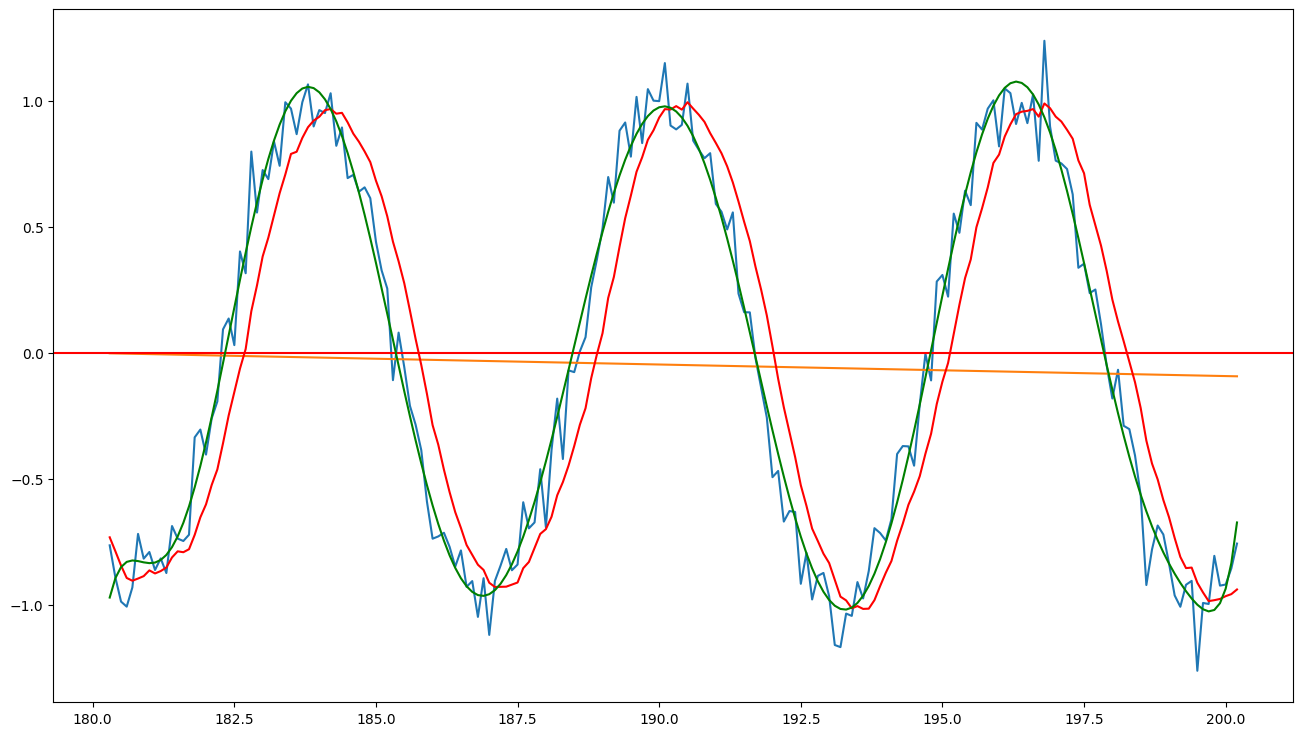

In [65]:
#График зашумленного сигнала, а также линия тренда, рассчитанная МНК (оранжевая), в сравнении с красной горизонтальной 
# линией, которая идет чётко по нулю


x = np.arange(-0.2, 200.3, 0.1)
sin_with_noise = np.genfromtxt('sin_with_noise_0_1.csv', delimiter=',')
sin_with_noise_ema = np.convolve(sin_with_noise, np.ones(8), 'valid') / 8



n = 200
sin_with_noise = sin_with_noise[ len(sin_with_noise) - n:]
sin_with_noise_ema = sin_with_noise_ema[ len(sin_with_noise_ema) - n:]
x = x[ len(x) - n :]

plt.figure(figsize=(16, 9))

#Отображение зашумленной функции
plt.plot(x, sin_with_noise)

#Рассчет и отображение линии тренда методом МНК
linear_polynomial = np.polyfit (x, sin_with_noise, 1)
trend_line = np.poly1d(linear_polynomial)
plt.plot (x, trend_line(x)) 

#Прмая, проходящая по нулю
plt.axhline(y = 0, color = 'r')

#=================================================================
#    Наглядно почему я выбрал экспоненциальную скользящую среднюю, а не, например, полином  МНК. Да полином более сглаженный, но в начале и 
# под конец  он ведет себя не как, например, в середине графика. Если представлять, что график движется в +∞ и постоянно 
# обновляется, то вместе с ним будет обновляться и полином, который в конце может показывать свою не валидность.  
# Скользящая же средняя всегда статична в плане поведения, хотя у неё тоже есть некоторые минусы.


#Экспоненциальная скользящая средняя
plt.plot(x, sin_with_noise_ema, color = 'r')

#Полином МНК, второй аргумент нужно менять в зависимости от рассматриваемого уровня шума
the_polynomial = np.polyfit (x, sin_with_noise, 120)
polynomial_ma = np.poly1d(the_polynomial)
plt.plot(x, polynomial_ma(x), color = 'g')
#=================================================================

plt.show()



# ㅤㅤㅤㅤОбучение модели способом 1 (с помощью модели LSTM) 
Данная модель была выбрана потому что если смотреть развертку LSTM, то там будут "хранится" её предыдущие состояния. Учитывая, что ряд у нас цикличный, то благодаря данной модели задача должна быть легко решаемой. 

Использовал среднеквадратичную ошибку в качестве функции потерь, так как она оценивает расстояние между сделанным прогнозом и целевым значением (а если точнее это сумма квадратов разности расстояний деленная на период, так сказать "средняя температура по больнице")

По хорошему, в самом начале обучения, нужно создавать сразу несколько одинаковых моделей  с разными начальными весами  и смотреть как они обучаются, так как у НС на основе метода back propagation есть особенность попадать в локальный минимум по функции потерь.

Для такой задачи нет смысла создавать много слоёв с большим количеством нейронов, так как она простая довольно. Да и в целом нужно создавать слоев и нейронов столько, сколько это необходимо, так как излишнее количество только ухудшает обучение и сильнее нагружает вычисления.

Можно было бы оставить и просто LSTM слой, но так как у него по дефолту функция активации гиперболический тангенс, насколько я помню, то значения будут от -1 до 1, а у нас при шуме значения бывают и больше 1, поэтому нам нужен дополнительный слой с линейной функции активации для числового предсказания шума 

Хотел, кстати, создать чекпоинты (чтобы ловить моменты переобучения и работать от этих точек) по эпохам, например, каждые 10 эпох, но немного не понял как. В итоге оставил эту затею, так как на сравнении тренировочной и валидационной выборки не увидел переобучения. Лосс фнукция валидационной выборки не шла наверх. Это ещё нужно на всякий случай, вдруг что случится, например, ноутбук забыл на зарядку поставить, а он во время обучения отключится. 

В качестве второй метрики оценивания выбрал MAE, так как он устойчив к данным с выбросами (хоть он и никак не влияет на обучение, тк не выбран в качестве лосс функции). 

In [380]:
# Загрузка данных 
name = 'sin_with_noise_0_1'

train_input = np.genfromtxt('input_train_' + name + '.csv', delimiter=',')
train_output = np.genfromtxt('output_train_' + name + '.csv', delimiter=',')

test_input = np.genfromtxt('input_test_' + name + '.csv', delimiter=',')
test_output = np.genfromtxt('output_test_' + name + '.csv', delimiter=',')

In [381]:
model = Sequential([
    LSTM(units = 8,  input_shape = (3,1)),
    Dense(8, activation='linear'),
    Dense(1, activation='linear')
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mean_absolute_error'])


history = model.fit(train_input, train_output, epochs=120, validation_split=0.3)

Epoch 1/120
33/33 [==============================] - 2s 16ms/step - loss: 0.6257 - mean_absolute_error: 0.7095 - val_loss: 0.5422 - val_mean_absolute_error: 0.6569
Epoch 2/120
33/33 [==============================] - 0s 4ms/step - loss: 0.4973 - mean_absolute_error: 0.6329 - val_loss: 0.4372 - val_mean_absolute_error: 0.5894
Epoch 3/120
33/33 [==============================] - 0s 4ms/step - loss: 0.4023 - mean_absolute_error: 0.5690 - val_loss: 0.3531 - val_mean_absolute_error: 0.5304
Epoch 4/120
33/33 [==============================] - 0s 4ms/step - loss: 0.3226 - mean_absolute_error: 0.5108 - val_loss: 0.2885 - val_mean_absolute_error: 0.4792
Epoch 5/120
33/33 [==============================] - 0s 5ms/step - loss: 0.2672 - mean_absolute_error: 0.4655 - val_loss: 0.2520 - val_mean_absolute_error: 0.4449
Epoch 6/120
33/33 [==============================] - 0s 4ms/step - loss: 0.2436 - mean_absolute_error: 0.4425 - val_loss: 0.2433 - val_mean_absolute_error: 0.4347
Epoch 7/120
33/33 [==

33/33 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.1173 - val_loss: 0.0198 - val_mean_absolute_error: 0.1116
Epoch 52/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.1145 - val_loss: 0.0191 - val_mean_absolute_error: 0.1091
Epoch 53/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0199 - mean_absolute_error: 0.1132 - val_loss: 0.0190 - val_mean_absolute_error: 0.1086
Epoch 54/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0198 - mean_absolute_error: 0.1129 - val_loss: 0.0189 - val_mean_absolute_error: 0.1094
Epoch 55/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0195 - mean_absolute_error: 0.1124 - val_loss: 0.0188 - val_mean_absolute_error: 0.1082
Epoch 56/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0204 - mean_absolute_error: 0.1149 - val_loss: 0.0195 - val_mean_absolute_error: 0.1105
Epoch 57/120
33/33 [=========

33/33 [==============================] - 0s 4ms/step - loss: 0.0189 - mean_absolute_error: 0.1104 - val_loss: 0.0202 - val_mean_absolute_error: 0.1132
Epoch 102/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0193 - mean_absolute_error: 0.1111 - val_loss: 0.0199 - val_mean_absolute_error: 0.1136
Epoch 103/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0187 - mean_absolute_error: 0.1095 - val_loss: 0.0188 - val_mean_absolute_error: 0.1079
Epoch 104/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0188 - mean_absolute_error: 0.1104 - val_loss: 0.0183 - val_mean_absolute_error: 0.1076
Epoch 105/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0190 - mean_absolute_error: 0.1098 - val_loss: 0.0189 - val_mean_absolute_error: 0.1079
Epoch 106/120
33/33 [==============================] - 0s 4ms/step - loss: 0.0185 - mean_absolute_error: 0.1089 - val_loss: 0.0183 - val_mean_absolute_error: 0.1075
Epoch 107/120
33/33 [===

In [373]:
#Функции для построения графиков

def plot_mse():
    # Обучение и проверка величины потерь

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend('Train', 'Test', loc='upper left')

    plt.show()
    
def plot_msa():
    # Обучение и проверка величины потерь

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('MSA')
    plt.ylabel('MSA')
    plt.xlabel('Epoch')
    plt.legend('Train', 'Test', loc='upper left')

    plt.show()

### Модель с LSTM для 'sin_with_noise_0_1'

In [364]:
model.evaluate(test_input, test_output)
model.save('model_LSTM_'+name)

16/16 [==============================] - 0s 2ms/step - loss: 0.0177 - mean_absolute_error: 0.1059
INFO:tensorflow:Assets written to: model_sin_with_noise_0_1\assets


INFO:tensorflow:Assets written to: model_sin_with_noise_0_1\assets


C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\1785422383.py:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


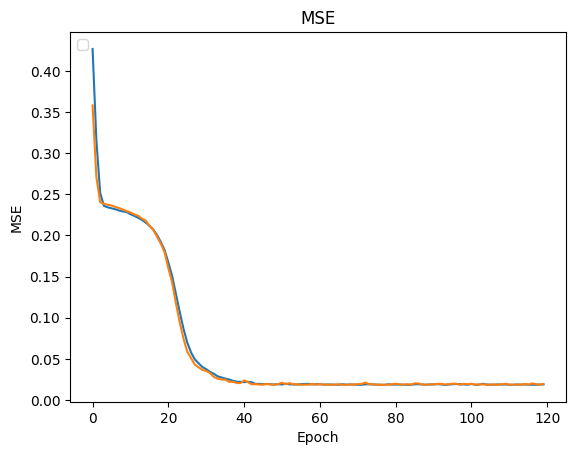

In [365]:
plot_mse()

C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\3331511249.py:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


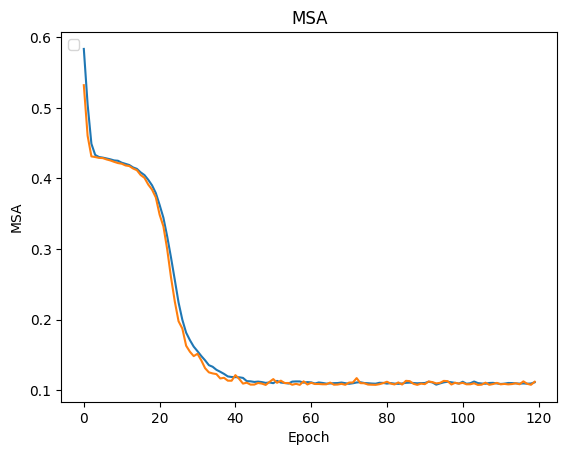

In [366]:
plot_msa()

### Модель с LSTM для 'sin_with_noise_0_3'

In [370]:
model.evaluate(test_input, test_output)
model.save('model_LSTM_'+name)

16/16 [==============================] - 0s 2ms/step - loss: 0.1555 - mean_absolute_error: 0.3186
INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_3\assets


INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_3\assets


C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\1785422383.py:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


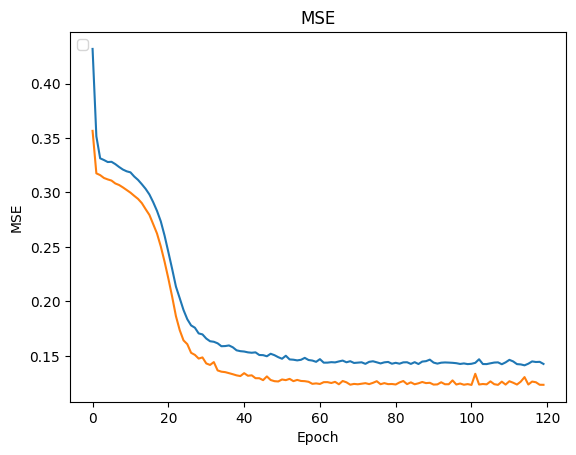

In [371]:
plot_mse()

C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\3331511249.py:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


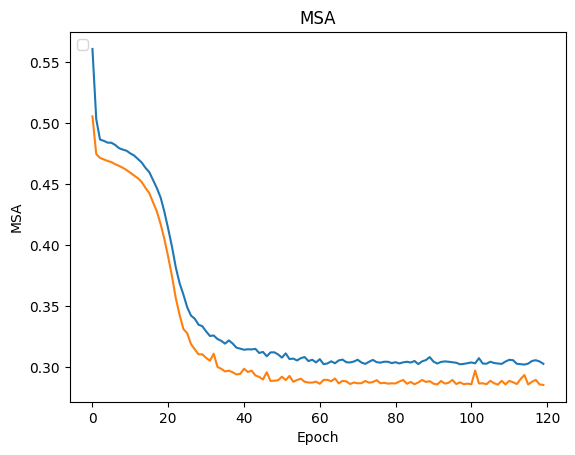

In [372]:
plot_msa()

### Модель с LSTM для 'sin_with_noise_0_5'

In [379]:
model.evaluate(test_input, test_output)
model.save('model_LSTM_'+name)

16/16 [==============================] - 0s 2ms/step - loss: 0.3685 - mean_absolute_error: 0.4917
INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_5\assets


INFO:tensorflow:Assets written to: model_LSTM_sin_with_noise_0_5\assets


C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\1863743727.py:10: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


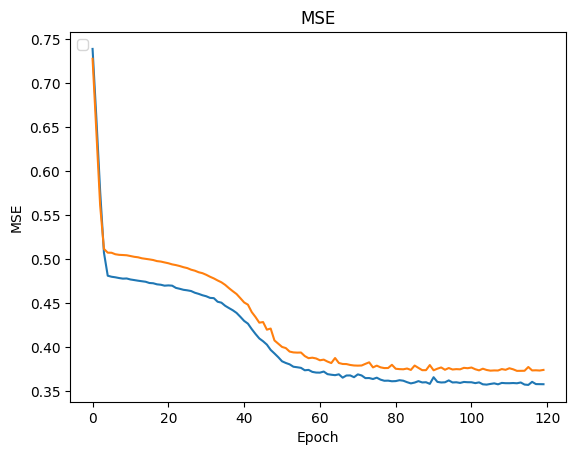

In [378]:
plot_mse()

C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\1863743727.py:23: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


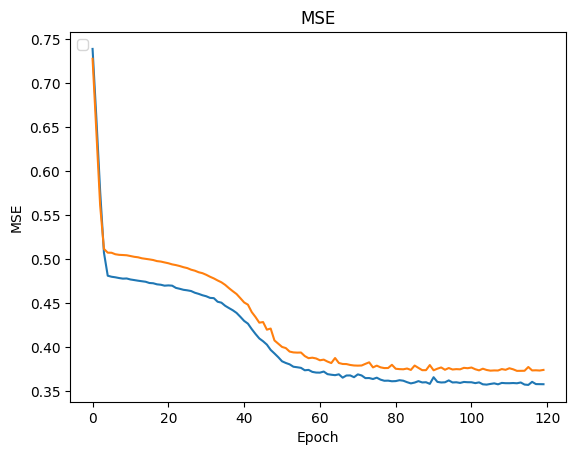

In [377]:
plot_msa()

# ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤОбучение модели способом 2 (RNN) 
Я не стал пробовать предсказать с помощью многослойного перцептрона (читал давно где-то), так как при такой задаче такие модели не обучаются из-за сквозной линейной зависимости слоев. Поэтому решил сравнить с простой RNN моделью и сравнить результаты.

In [418]:
#Функции для построения графиков

def plot_mse():
    # Обучение и проверка величины потерь
    plt.figure(figsize=(16, 9))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend('Train', 'Test', loc='upper left')

    plt.show()
    
def plot_msa():
    # Обучение и проверка величины потерь
    plt.figure(figsize=(16, 9))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend('Train', 'Test', loc='upper left')

    plt.show()

In [431]:
# Загрузка данных 
name = 'sin_with_noise_0_5'

train_input = np.genfromtxt('input_train_' + name + '.csv', delimiter=',')
train_output = np.genfromtxt('output_train_' + name + '.csv', delimiter=',')

test_input = np.genfromtxt('input_test_' + name + '.csv', delimiter=',')
test_output = np.genfromtxt('output_test_' + name + '.csv', delimiter=',')

In [432]:
model = Sequential([
    SimpleRNN(units = 8, input_shape = (3,1)),
    Dense(8, activation='linear'),
    Dense(1, activation='linear')
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mean_absolute_error'])


history = model.fit(train_input, train_output, epochs=120, validation_split=0.3)

Epoch 1/120
33/33 [==============================] - 1s 9ms/step - loss: 0.4559 - mean_absolute_error: 0.5420 - val_loss: 0.4662 - val_mean_absolute_error: 0.5462
Epoch 2/120
33/33 [==============================] - 0s 3ms/step - loss: 0.4267 - mean_absolute_error: 0.5207 - val_loss: 0.4426 - val_mean_absolute_error: 0.5299
Epoch 3/120
33/33 [==============================] - 0s 3ms/step - loss: 0.4104 - mean_absolute_error: 0.5084 - val_loss: 0.4223 - val_mean_absolute_error: 0.5185
Epoch 4/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3981 - mean_absolute_error: 0.4975 - val_loss: 0.4060 - val_mean_absolute_error: 0.5060
Epoch 5/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3838 - mean_absolute_error: 0.4873 - val_loss: 0.3985 - val_mean_absolute_error: 0.5014
Epoch 6/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3744 - mean_absolute_error: 0.4807 - val_loss: 0.3911 - val_mean_absolute_error: 0.4940
Epoch 7/120
33/33 [===

33/33 [==============================] - 0s 3ms/step - loss: 0.3588 - mean_absolute_error: 0.4668 - val_loss: 0.3758 - val_mean_absolute_error: 0.4859
Epoch 52/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3584 - mean_absolute_error: 0.4671 - val_loss: 0.3756 - val_mean_absolute_error: 0.4864
Epoch 53/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3583 - mean_absolute_error: 0.4671 - val_loss: 0.3754 - val_mean_absolute_error: 0.4852
Epoch 54/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3583 - mean_absolute_error: 0.4676 - val_loss: 0.3760 - val_mean_absolute_error: 0.4874
Epoch 55/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3605 - mean_absolute_error: 0.4680 - val_loss: 0.3756 - val_mean_absolute_error: 0.4861
Epoch 56/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3585 - mean_absolute_error: 0.4672 - val_loss: 0.3759 - val_mean_absolute_error: 0.4855
Epoch 57/120
33/33 [=========

33/33 [==============================] - 0s 3ms/step - loss: 0.3582 - mean_absolute_error: 0.4694 - val_loss: 0.3741 - val_mean_absolute_error: 0.4844
Epoch 102/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3576 - mean_absolute_error: 0.4684 - val_loss: 0.3749 - val_mean_absolute_error: 0.4869
Epoch 103/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3562 - mean_absolute_error: 0.4660 - val_loss: 0.3749 - val_mean_absolute_error: 0.4847
Epoch 104/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3552 - mean_absolute_error: 0.4663 - val_loss: 0.3840 - val_mean_absolute_error: 0.4945
Epoch 105/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3581 - mean_absolute_error: 0.4687 - val_loss: 0.3743 - val_mean_absolute_error: 0.4850
Epoch 106/120
33/33 [==============================] - 0s 3ms/step - loss: 0.3575 - mean_absolute_error: 0.4683 - val_loss: 0.3781 - val_mean_absolute_error: 0.4858
Epoch 107/120
33/33 [===

### Модель RNN  для 'sin_with_noise_0_1'

In [423]:
model.evaluate(test_input, test_output)
model.save('model_RNN_'+name)

16/16 [==============================] - 0s 2ms/step - loss: 0.0176 - mean_absolute_error: 0.1090
INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_1\assets


INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_1\assets


C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\2890101345.py:12: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


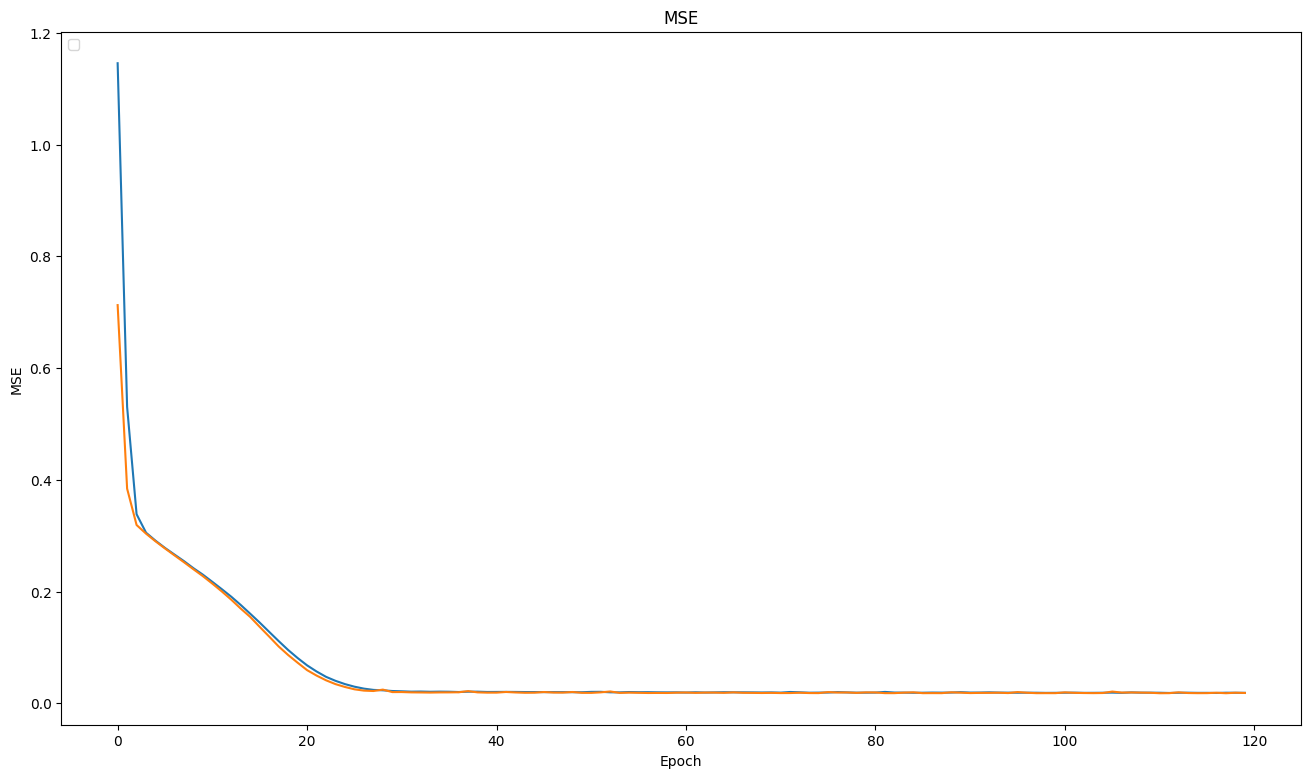

In [424]:
plot_mse()

C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\2890101345.py:25: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


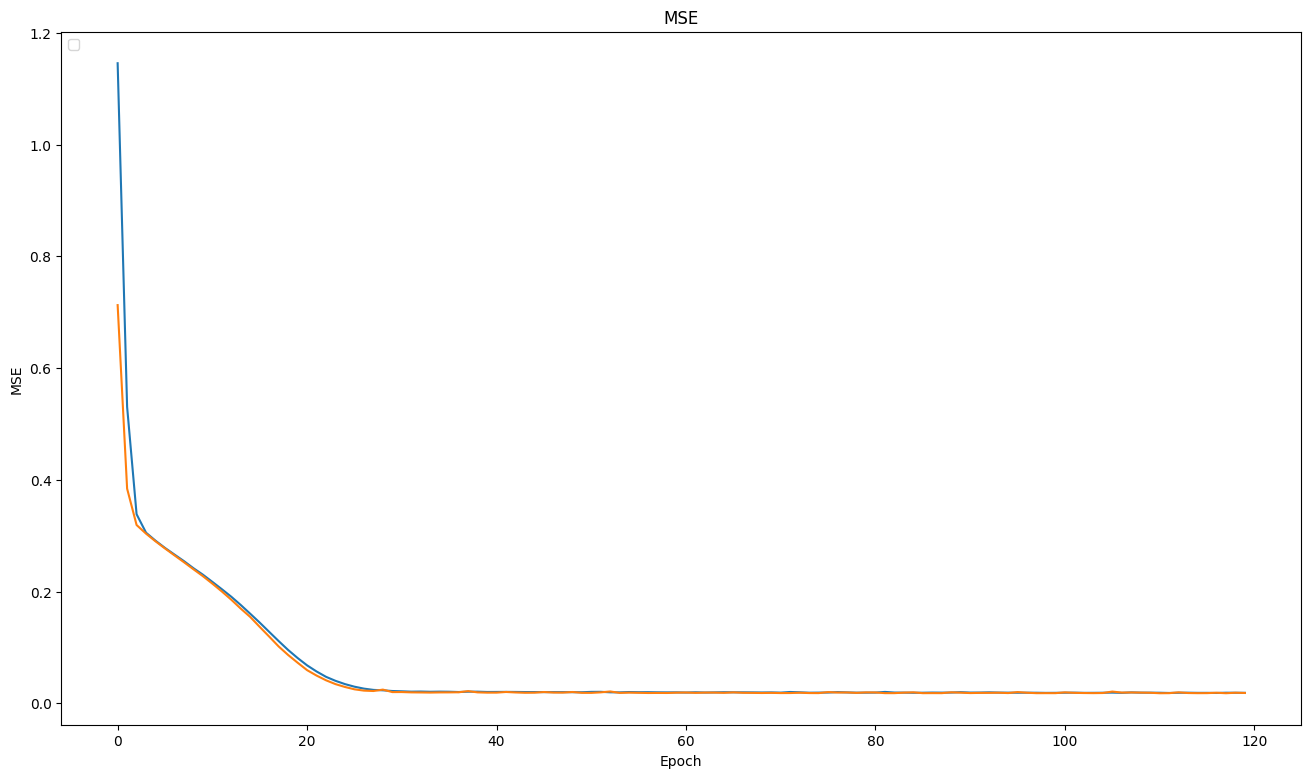

In [425]:
plot_msa()

### Модель RNN  для 'sin_with_noise_0_3'

In [428]:
model.evaluate(test_input, test_output)
model.save('model_RNN_'+name)

16/16 [==============================] - 0s 1ms/step - loss: 0.1582 - mean_absolute_error: 0.3172
INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_3\assets


INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_3\assets


C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\2890101345.py:12: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


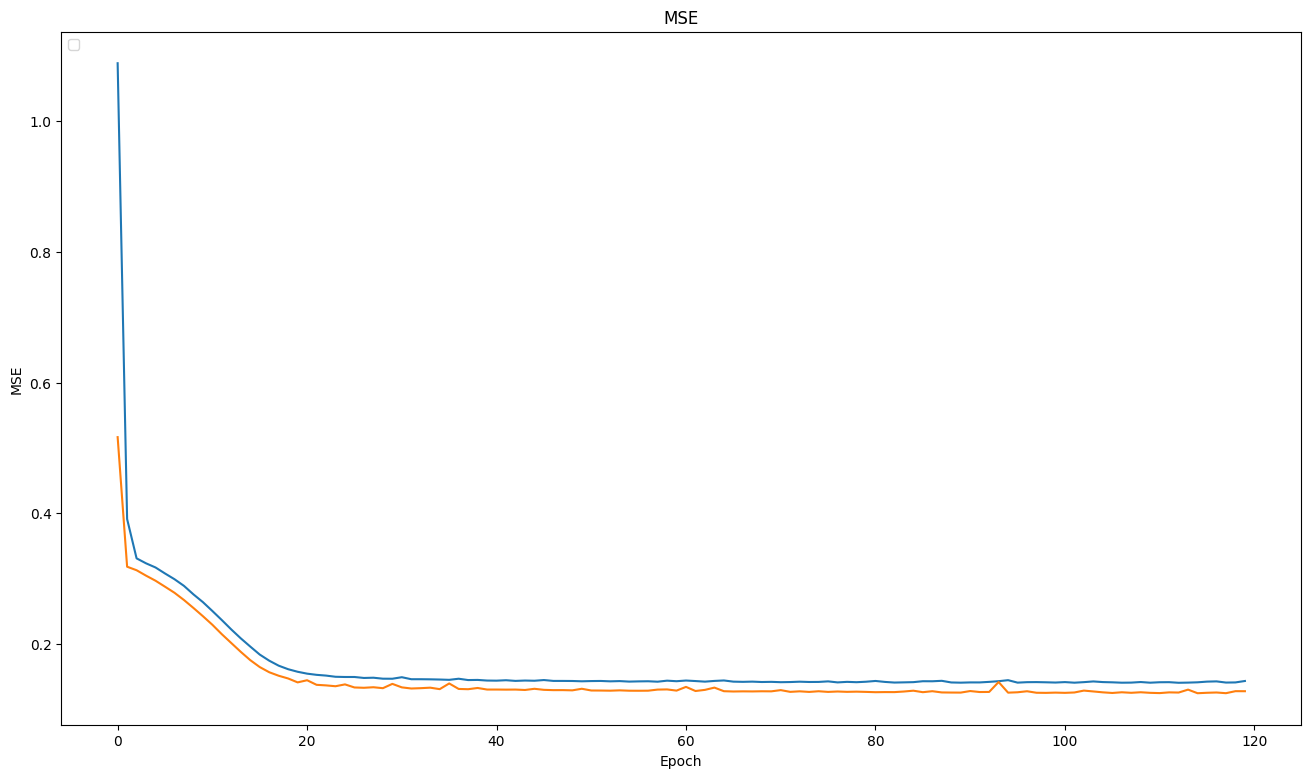

In [429]:
plot_mse()

C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\2890101345.py:25: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


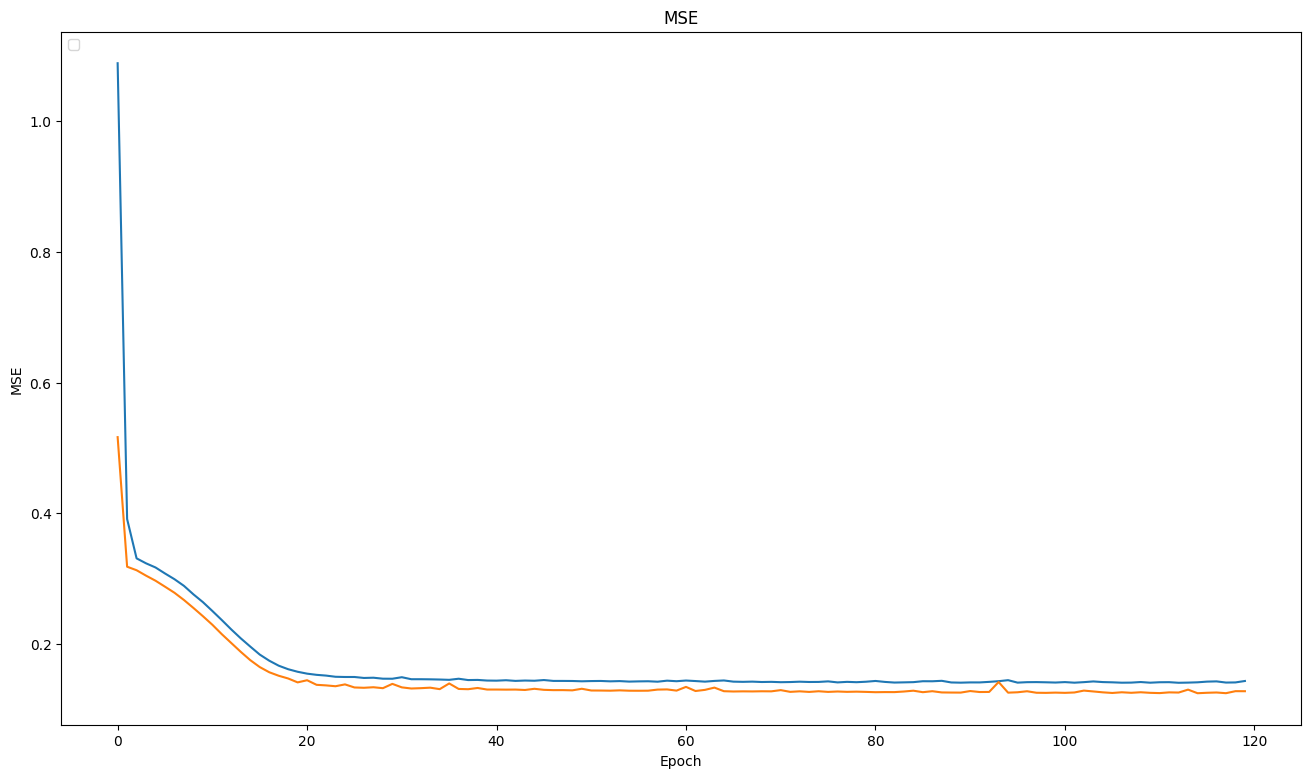

In [430]:
plot_msa()

### Модель RNN  для 'sin_with_noise_0_5'

In [433]:
model.evaluate(test_input, test_output)
model.save('model_RNN_'+name)

16/16 [==============================] - 0s 1ms/step - loss: 0.3652 - mean_absolute_error: 0.4903
INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_5\assets


INFO:tensorflow:Assets written to: model_RNN_sin_with_noise_0_5\assets


C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\2890101345.py:12: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


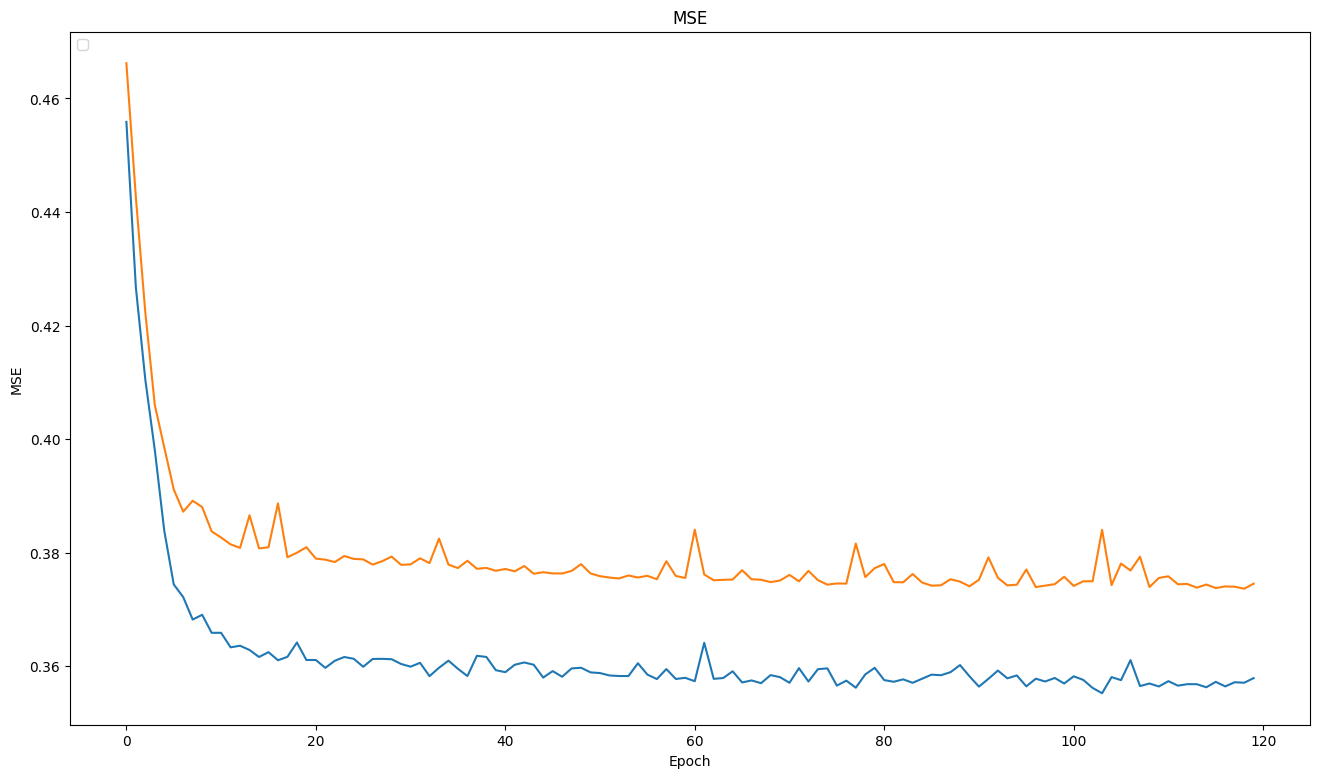

In [434]:
plot_mse()

C:\Users\Aleks\AppData\Local\Temp\ipykernel_11868\2890101345.py:25: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Train', 'Test', loc='upper left')


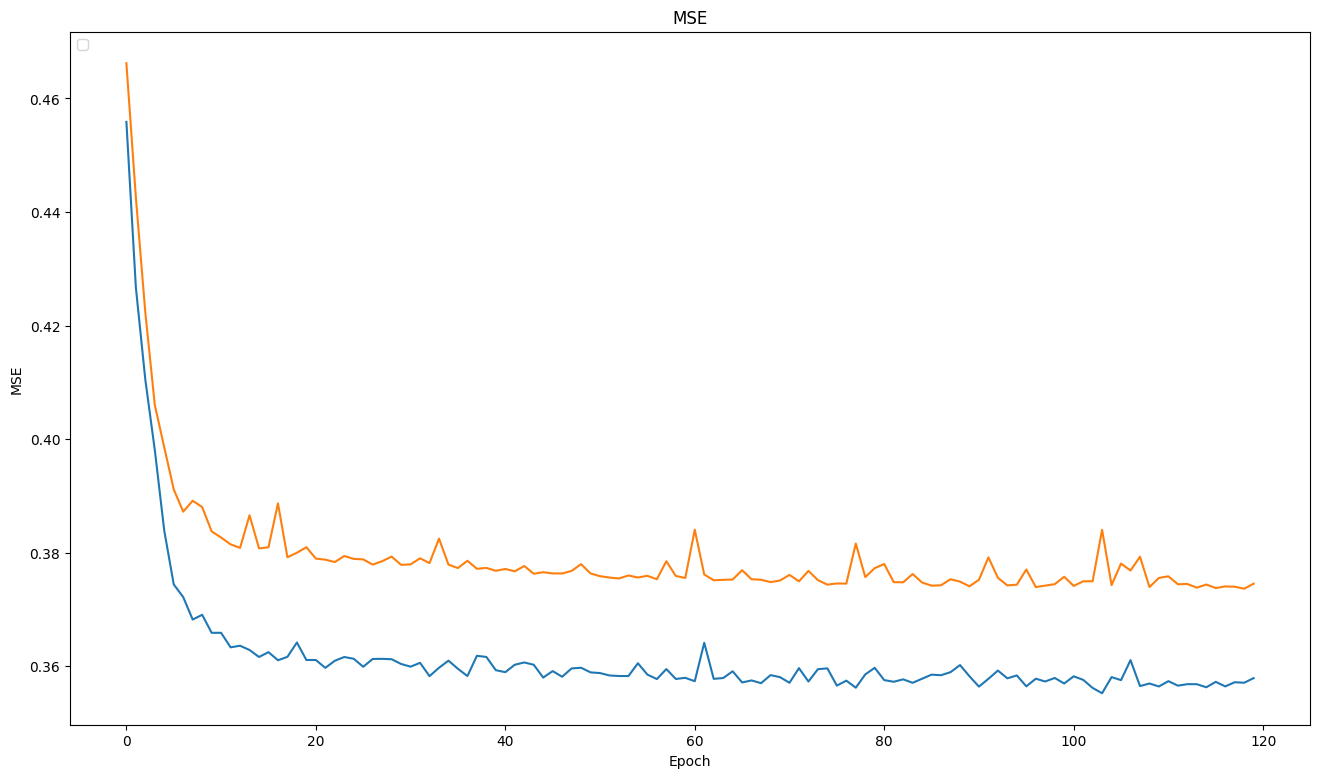

In [435]:
plot_msa()

# ㅤㅤㅤㅤㅤㅤРабота обученной модели на тестовой выборке

16/16 [==============================] - 0s 2ms/step


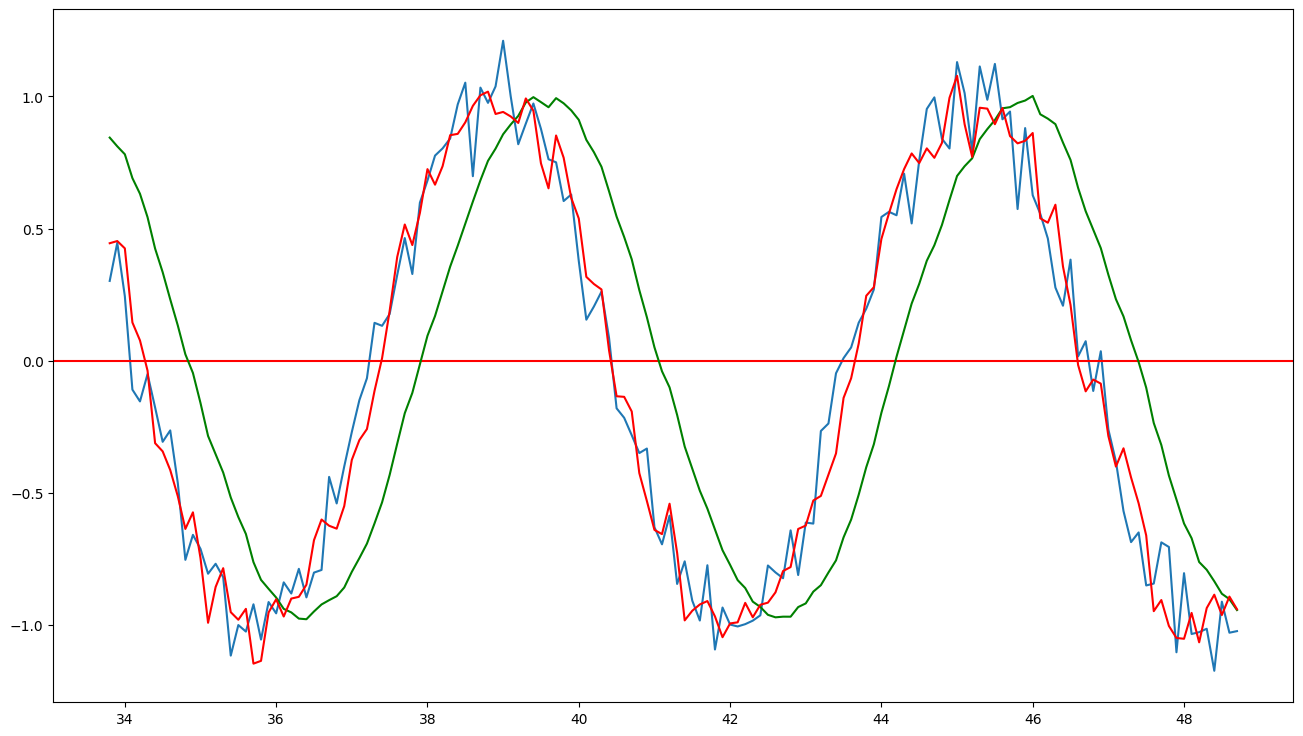

In [437]:

model = keras.models.load_model('model_LSTM_sin_with_noise_0_1')

name = 'sin_with_noise_0_1'




input_test = np.genfromtxt('input_test_' + name + '.csv', delimiter=',')
sin_with_noise = np.genfromtxt('output_test_' + name + '.csv', delimiter=',')

predictions = model.predict(input_test)
    
x = x = np.arange(0, len(sin_with_noise)*0.1, 0.1)  
    
ema = input_test[:, 2] 
    
    
    
 #Показ последних 150 точек, можно закомментитить при желании
x, ema, sin_with_noise, predictions = x[len(x)-150 :], ema[len(x)-150 :], sin_with_noise[len(x)-150 :], predictions[len(x)-150 :]
    
plt.figure(figsize=(16, 9))

#Отображение зашумленной функции
plt.plot(x, sin_with_noise)
 

#Прмая, проходящая по нулю
plt.axhline(y = 0, color = 'r')


#Экспоненциальная скользящая средняя
plt.plot(x, ema, color = 'g')

# #Предсказание
plt.plot(x, predictions, color = 'r')


plt.show()

#  ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤВыводы

1) По результатам можно сделать вывод, что при обучении RNN и LSTM моделей показатели обучения примерно одни и те же. Из предложенных моделей (а я уверен, что можно добиться и лучших результатов, если экспериментировать с Dense слоями и количеством нейронов) можно, для соответствующих шумов, выбрать одну из предложенных моделей, при этом они не будут кардинально различаться между собой.


2) Визуально предсказанные значения повторяют шум, пусть и с некоторой погрешностью. И чем меньше шум, тем меньше среднее расстояние от предсказанного значения до шума. И это вполне очевидно, ведь чем сильнее шум, тем больше разброс по оси y его значения. 

3) При увеличении шума модель все равно имеет способность предсказания

#  ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤДомашнее задание

Понимаю, это не вовремя, но все же это домашнее задание + мне было интересно. Про нормализацию нестационарных рядов еще позже почитаю

1) 5 моментов мат. стата: мат.ожидание, дисперсия, отклонения, корреляции, выборки

2. Как нормализовать нестационарный ряд? Например, через дифференцирование 
https://digitrain.ru/articles/34402/


3)

In [442]:
a = [1, 2, 3, 4, 5]
b = [6, 7, 8, 9, 10]

len(a) * (sum(a) +sum(b))

275

# Черновик

In [334]:
data = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
output_data = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

n = 8
data_ema = moving_avg(data, n)
data, output_data = data[n-1:], output_data[n-1:]

print(data_ema)
print(output_data)

[ 3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5
 17.5 18.5 19.5 20.5 21.5]
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]


In [335]:
roll_1 = np.roll(data_ema, 1)
roll_2 = np.roll(data_ema, 2)

print(roll_2)
print(roll_1)
print(data_ema)

[20.5 21.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5
 15.5 16.5 17.5 18.5 19.5]
[21.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5
 16.5 17.5 18.5 19.5 20.5]
[ 3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5
 17.5 18.5 19.5 20.5 21.5]


In [336]:
input_data, data, output_data = input_data[2:len(input_data)-3], data[2:len(input_data)-3], output_data[5:]

print("Скользяшки, которые будут подаваться в нейросеть")
print(input_data)
print("Значения, которые соответствуют скользяшкам")
print(data)
print("Значения, с которым будет сравниваться прогноз (целевые данные)")
print(output_data)

print(len(input_data), len(data), len(output_data))

Скользяшки, которые будут подаваться в нейросеть
[[ 5.5  6.5  7.5]
 [ 6.5  7.5  8.5]
 [ 7.5  8.5  9.5]
 [ 8.5  9.5 10.5]
 [ 9.5 10.5 11.5]
 [10.5 11.5 12.5]
 [11.5 12.5 13.5]
 [12.5 13.5 14.5]
 [13.5 14.5 15.5]]
Значения, которые соответствуют скользяшкам
[ 9 10 11 12 13 14 15 16 17]
Значения, с которым будет сравниваться прогноз (целевые данные)
[12 13 14 15 16 17 18 19 20 21 22 23 24 25]
9 9 14


In [ ]:
До